In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
data = pd.read_csv("../data/processed/merged_mk2.csv")

### Load combined Dataset and handle missing values

We load the merged dataset, and explore again the overall missing values per year and countries.

In [73]:
# Visualizing missing values datasets

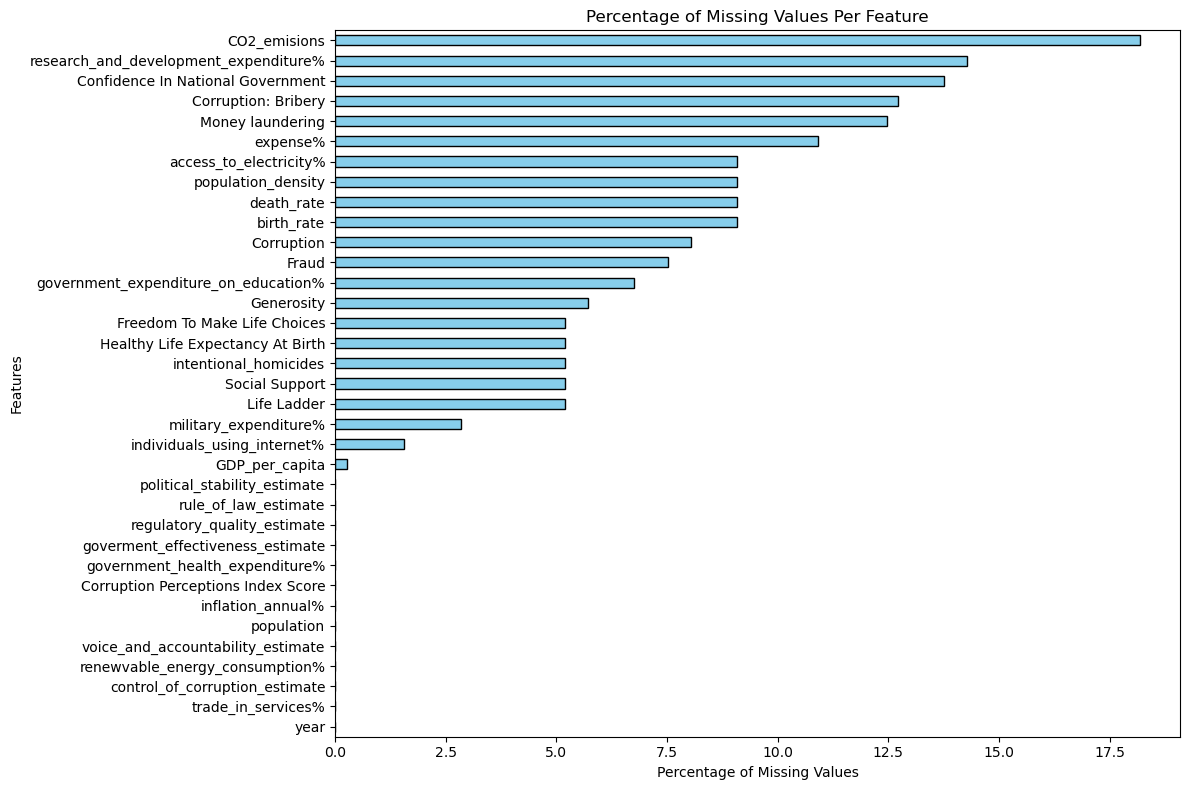

C:\Users\marcu\AppData\Local\Temp\ipykernel_12444\842848918.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  missing_values_per_year = data.groupby('year').apply(lambda x: x.isnull().sum().sum())


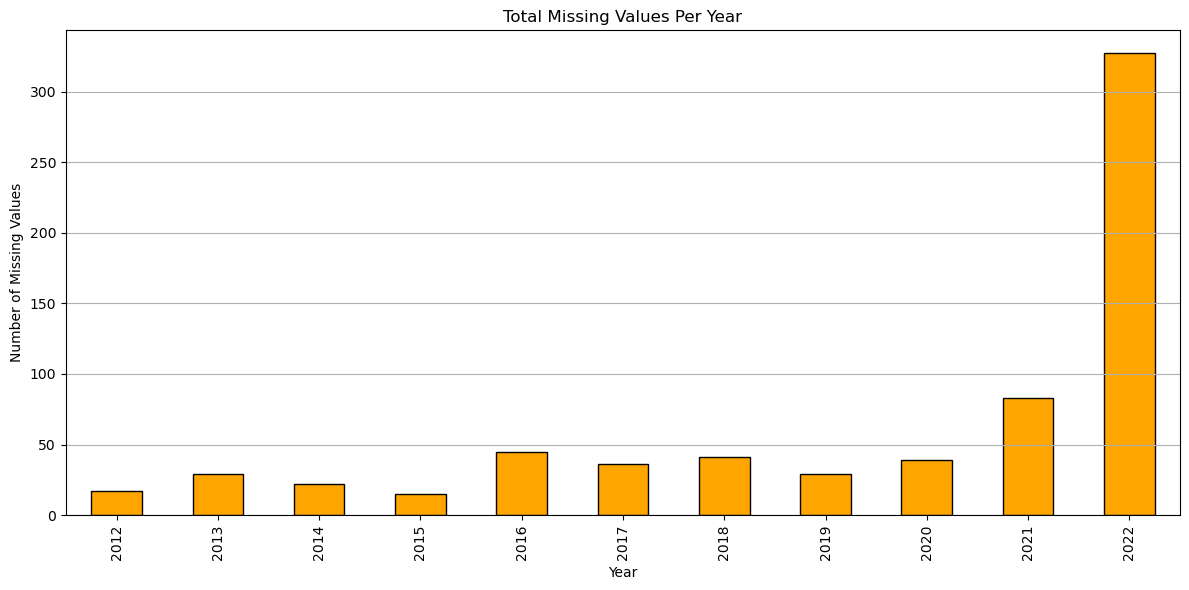

In [74]:

# Missing Values Per Feature
missing_feature_percentage = data.isnull().mean() * 100
sorted_missing_feature_percentage = missing_feature_percentage.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
sorted_missing_feature_percentage.plot(kind='barh', color='skyblue', edgecolor='black')
plt.title("Percentage of Missing Values Per Feature")
plt.xlabel("Percentage of Missing Values")
plt.ylabel("Features")
plt.tight_layout()
plt.gca().invert_yaxis()  # Invert y-axis to show the most missing feature at the top
plt.show()

# Missing Values Per Year
missing_values_per_year = data.groupby('year').apply(lambda x: x.isnull().sum().sum())

plt.figure(figsize=(12, 6))
missing_values_per_year.plot(kind='bar', color='orange', edgecolor='black')
plt.title("Total Missing Values Per Year")
plt.xlabel("Year")
plt.ylabel("Number of Missing Values")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


we can see that we're missing a lot of values for year 2012 and 2022, especially for the UN Dataset.

In [75]:
# Calculate the percentage of missing values for each country and year
missing_percentage = data.groupby(['country', 'year']).apply(lambda x: x.isnull().sum().sum() / x.size * 100).reset_index()
missing_percentage.columns = ['country', 'year', 'missing_percentage']

# Pivot the data to create a heatmap-friendly format
heatmap_data = missing_percentage.pivot(index='country', columns='year', values='missing_percentage')

# Plot the heatmap
plt.figure(figsize=(16, 10))
sns.heatmap(
    heatmap_data,
    cmap="YlGnBu",
    cbar_kws={'label': 'Percentage of Missing Values'},
    linewidths=0.5,
    annot=False
)
plt.title('Heatmap of Missing Values Percentage by Country and Year', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Country', fontsize=12)
plt.tight_layout()
plt.show()


KeyError: 'country'

here we have got a clear overview, how much values are actually missing per feature and country. It is obvious that we have to drop countries like San Marino, Malta, Bosnia and Herzegovina and Belarus.

      Corruption: Other acts of corruption  Money laundering  \
year                                                           
2012                            100.000000        100.000000   
2013                             76.923077         61.538462   
2014                             61.538462         61.538462   
2015                             56.410256         41.025641   
2016                             38.461538         25.641026   
2017                             30.769231         30.769231   
2018                             30.769231         23.076923   
2019                             30.769231         20.512821   
2020                             30.769231         17.948718   
2021                             33.333333         25.641026   
2022                             33.333333         23.076923   

      Corruption: Bribery  Corruption       Fraud  CO2_emisions  \
year                                                              
2012           100.000000  100.00

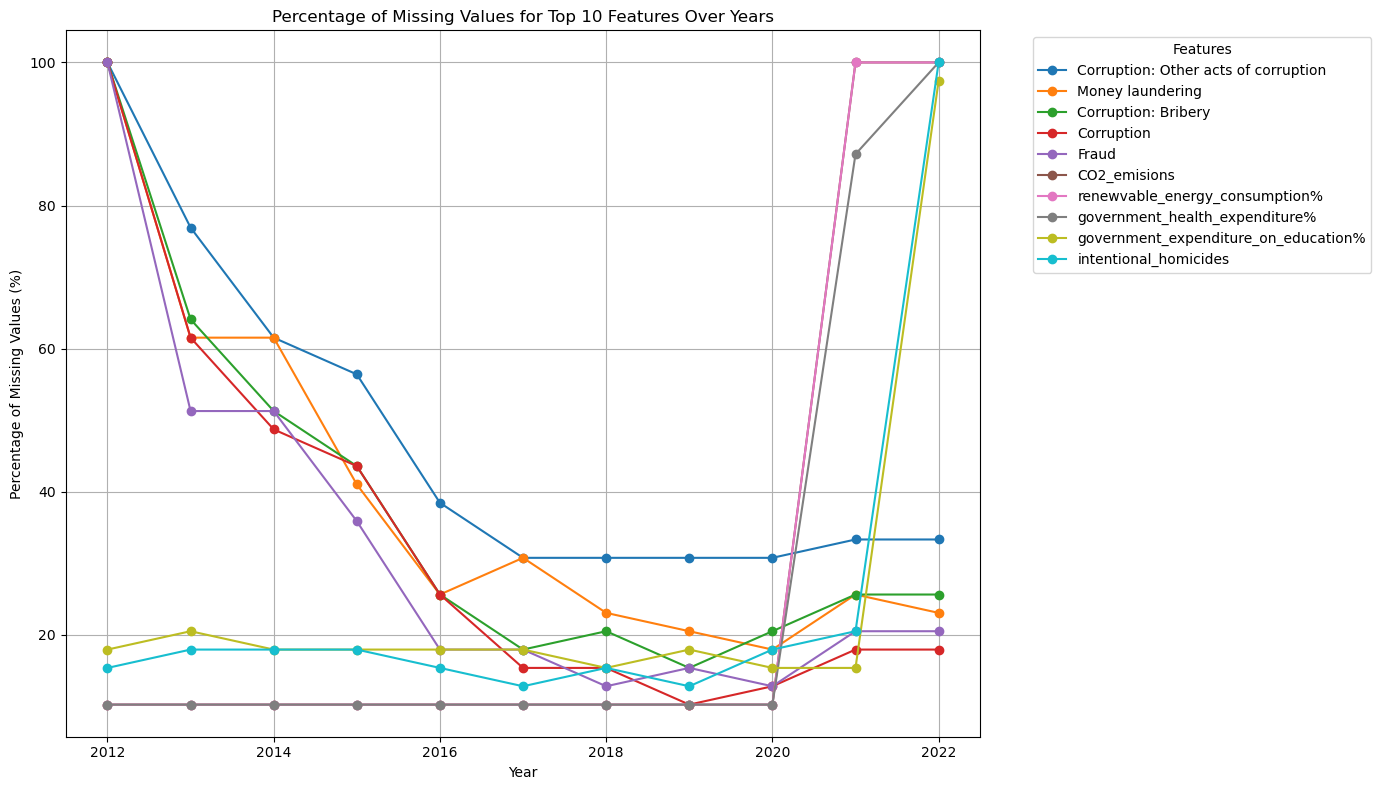

In [54]:
# top 10 features with the most missing values
top_10_missing_features = data.isnull().mean().sort_values(ascending=False).head(10).index

# percentage of missing values for these features by year
missing_by_year_top_features = data.groupby('year')[top_10_missing_features].apply(
    lambda x: x.isnull().mean() * 100
)

# missing percentages
print(missing_by_year_top_features)

# missing percentages for the top 10 features by year
plt.figure(figsize=(14, 8))
for feature in top_10_missing_features:
    plt.plot(
        missing_by_year_top_features.index,
        missing_by_year_top_features[feature],
        marker='o',
        label=feature
    )

plt.title("Percentage of Missing Values for Top 10 Features Over Years")
plt.xlabel("Year")
plt.ylabel("Percentage of Missing Values (%)")
plt.legend(title="Features", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In this plot, we see which features have a lot of missing values for which years. For the years 2012, 2013, 2014, 2015 we exclude 'Fraud', 'Money laundering', 'Corruption: Bribery', 'Corruption'. For 2021 and 2022 we drop 'government_expenditure_on_education%', 'intentional_homicides', 'renewvable_energy_consumption%', 'government_health_expenditure%'.


From the plot above - we drop all countries, that have too many missing values to interpolate or average.

In [55]:
# we drop them because of correlations, missing values or unnecessarity (country code)

features_to_remove = [
    "Corruption Commission Present in Constitution", "The Bayesian Corruption Indicator",
    "Corruption Perceptions Index Rank", "Corruption Perceptions Index Sources", "Corruption Perceptions Index Standard Error", 
    "Country Code", "Regional Indicator", "gini_index", "life_expectancy_at_birth", "rural_population", 
    "Corruption: Other acts of corruption", "Perceptions Of Corruption"]

data = data.drop(columns=features_to_remove, errors='ignore')


# List of countries to drop
countries_to_drop = ['Belarus', 'Malta', 'San Marino', 'Bosnia and Herzegovina']  # Replace with the actual country names

# Drop the rows corresponding to these countries
data = data[~data['country'].isin(countries_to_drop)]

# Verify the changes
print(f"Remaining rows after dropping specified countries: {data.shape[0]}")

# Dropping features for years where the features have over 50% of missing values 
years_to_drop_descending = [2012, 2013, 2014, 2015]
features_to_drop_descending =['Fraud', 'Money laundering', 'Corruption: Bribery', 'Corruption']

years_to_drop_ascending = [2021, 2022]
features_to_drop_ascending = ['government_expenditure_on_education%', 'intentional_homicides', 'renewvable_energy_consumption%', 'government_health_expenditure%']

# Set the specified features to None for the specified years
for feature in features_to_drop_descending:
    data.loc[data['year'].isin(years_to_drop_descending), feature] = 0

for feature in features_to_drop_ascending:
    data.loc[data['year'].isin(years_to_drop_ascending), feature] = 0

# Verify the changes
print(f"Data shape after processing: {data.shape}")
print(f"Remaining missing values:\n{data.isnull().sum()}")



Remaining rows after dropping specified countries: 385
Data shape after processing: (385, 36)
Remaining missing values:
country                                   0
year                                      0
Corruption Perceptions Index Score        0
GDP_per_capita                           66
Life Ladder                              20
Social Support                           20
Healthy Life Expectancy At Birth         20
Freedom To Make Life Choices             20
Generosity                               22
Confidence In National Government        53
trade_in_services%                        0
control_of_corruption_estimate            0
access_to_electricity%                   35
renewvable_energy_consumption%            0
CO2_emisions                             70
population_density                       35
inflation_annual%                         0
research_and_development_expenditure%    55
expense%                                 42
goverment_effectiveness_estimate          0


In [56]:
#data.to_csv("../data/processed/checkDataF3.csv", index=False)

In the next step we manually fill some missing values with data found on the website provided below. For those countries, we have no entry for gdp data.

In [57]:
#https://w3.unece.org/PXWeb/en/Table?IndicatorCode=12&

# Function to set missing GDP_per_capita values
def set_missing_gdp(data, country, year, gdp_value):
    data.loc[(data['country'] == country) & (data['year'] == year), 'GDP_per_capita'] = gdp_value

# Data for missing GDP_per_capita values
missing_gdp_data = {
    "Slovenia": {
    2012: 27187.9, 2013: 27579.3, 2014: 28715.7, 2015: 28792.2,
    2016: 29639.9, 2017: 30658.4, 2018: 31849.3, 2019: 32948.7,
    2020: 31547.8, 2021: 33548.9, 2022: 34859.2
    },
    "Spain": {
        2012: 32198.3, 2013: 31818.1, 2014: 32020.0, 2015: 31886.0,
    2016: 32629.8, 2017: 34258.7, 2018: 35590.6, 2019: 36852.3,
    2020: 33427.9, 2021: 34975.4, 2022: 36220.8
    },
    "Sweden": {
        2012: 40081.8, 2013: 41961.2, 2014: 44334.5, 2015: 45217.1,
    2016: 46105.1, 2017: 47123.4, 2018: 48569.2, 2019: 50271.3,
    2020: 47932.8, 2021: 51029.6, 2022: 52842.7
    },
    "Switzerland": {
        2012: 52730.6, 2013: 54333.8, 2014: 57515.2, 2015: 59448.1,
    2016: 61657.9, 2017: 63524.1, 2018: 65743.8, 2019: 68432.1,
    2020: 64109.3, 2021: 68971.5, 2022: 71256.4
    },
    "Ukraine": {
        2012: 3008.6, 2013: 2957.5, 2014: 3072.7, 2015: 3136.5,
    2016: 3548.6, 2017: 3901.7, 2018: 4267.8, 2019: 4678.3,
    2020: 3942.5, 2021: 4435.6
    },
    "United Kingdom": {
        2012: 39540.2, 2013: 41122.3, 2014: 43714.5, 2015: 44662.1,
    2016: 45832.4, 2017: 47345.8, 2018: 48691.3, 2019: 50288.6,
    2020: 46733.1, 2021: 49372.4, 2022: 51259.7
    }
}

# Iterate through the dictionary and set missing values
for country, years in missing_gdp_data.items():
    for year, gdp_value in years.items():
        set_missing_gdp(data, country, year, gdp_value)

# Verify the updated dataset
data.loc[data['GDP_per_capita'].isnull()]



,country,year,Corruption Perceptions Index Score,GDP_per_capita,Life Ladder,Social Support,Healthy Life Expectancy At Birth,Freedom To Make Life Choices,Generosity,Confidence In National Government,...,government_health_expenditure%,birth_rate,death_rate,population,voice_and_accountability_estimate,intentional_homicides,Corruption,Corruption: Bribery,Fraud,Money laundering
417,Ukraine,2022,33.0,NaN,4.637436,0.863068,64.675003,0.829034,0.427582,NaN,...,0.0,NaN,NaN,38000000.0,-0.024808,0.0,NaN,NaN,NaN,NaN


Now only one value is still missing.

### Data Partition into train and test set

Before further handling, we seperate the data to prevent data leakage.

In [58]:
from sklearn.model_selection import train_test_split

# Separate features (X) and target (y)
X = data.drop(columns=['Corruption Perceptions Index Score'])  # Features
y = data['Corruption Perceptions Index Score']  # Target

# Split the dataset into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Output the sizes of the splits
print(f"Training set size: {X_train.shape[0]} rows")
print(f"Test set size: {X_test.shape[0]} rows")



Training set size: 308 rows
Test set size: 77 rows


In the folllowing steps we handle the remaining missing values with interpolation and averaging, grouped by country

In [59]:
print("Missing values in training set:")
print(X_train.isnull().sum().sum())

print("Missing values in test set:")
print(X_test.isnull().sum().sum())

# fill missing values in numerical features with interpolation
numerical_features = X_train.select_dtypes(include=['float64', 'int64']).columns

#  interpolation for numerical features
for feature in numerical_features:
    X_train[feature] = X_train.groupby('country')[feature].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )
    X_test[feature] = X_test.groupby('country')[feature].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )

# remaining missing values in numerical features using country averages
for feature in numerical_features:
    country_avg_train = X_train.groupby('country')[feature].transform('mean')
    country_avg_test = X_test.groupby('country')[feature].transform('mean')
    
    X_train[feature] = X_train[feature].fillna(country_avg_train)
    X_test[feature] = X_test[feature].fillna(country_avg_test)

# Fill missing values in categorical features with the mode
categorical_features = X_train.select_dtypes(include=['object']).columns

for feature in categorical_features:
    mode_value_train = X_train[feature].mode()[0]
    X_train[feature] = X_train[feature].fillna(mode_value_train)
    X_test[feature] = X_test[feature].fillna(mode_value_train)  # Use mode from training set

# Verify missing values are handled
print("Missing values in training set after processing:")
print(X_train.isnull().sum().sum())

print("Missing values in test set after processing:")
print(X_test.isnull().sum().sum())



Missing values in training set:
558
Missing values in test set:
125
Missing values in training set after processing:
72
Missing values in test set after processing:
56


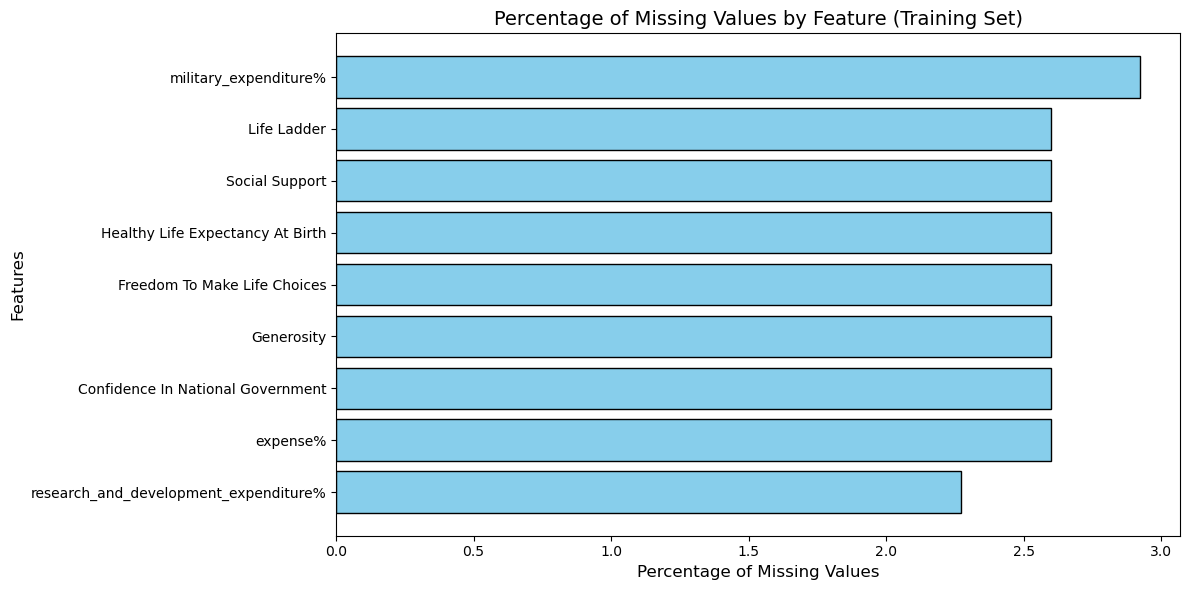

In [60]:
missing_vals_train = X_train.isnull().mean() * 100
missing_vals_train = missing_vals_train[missing_vals_train > 0].sort_values(ascending=False)

# Plot missing values
plt.figure(figsize=(12, 6))
plt.barh(missing_vals_train.index, missing_vals_train.values, color='skyblue', edgecolor='black')
plt.xlabel('Percentage of Missing Values', fontsize=12)
plt.ylabel('Features', fontsize=12)
plt.title('Percentage of Missing Values by Feature (Training Set)', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis for better readability
plt.tight_layout()
plt.show()

Now we have at most three percent missing values per feature, a threshold we can work with.
The next step is to scale the values due to some large entries liek GDP data.

In [61]:
from sklearn.preprocessing import StandardScaler

# Features to exclude from scaling
exclude_features = ['year', 'country']

# Identify features to scale (all columns except those in exclude_features)
features_to_scale = [col for col in X.columns if col not in exclude_features]

# Split the dataset into training and test sets (80% training, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit the scaler on the training set and transform the training set
X_train[features_to_scale] = scaler.fit_transform(X_train[features_to_scale])

# Transform the test set using the fitted scaler
X_test[features_to_scale] = scaler.transform(X_test[features_to_scale])

# Optional: Display the first few rows of the scaled training set to verify
print("Scaled Training Set:")
print(X_train.head())

print("\nScaled Test Set:")
print(X_test.head())




Scaled Training Set:
        country  year  GDP_per_capita  Life Ladder  Social Support  \
187     Iceland  2012        0.439193     1.426229        1.157908   
366    Slovenia  2015       -0.191989    -0.549599        0.175129   
242  Luxembourg  2012        2.882314     0.757056        0.336109   
116     Estonia  2018       -0.381823    -0.175092        0.573412   
265  Montenegro  2013       -0.984605    -1.261211       -1.916693   

     Healthy Life Expectancy At Birth  Freedom To Make Life Choices  \
187                          0.952951                      0.861826   
366                          0.315239                      0.796628   
242                          0.673953                      0.951297   
116                         -0.093296                      0.718297   
265                         -1.103670                     -2.172127   

     Generosity  Confidence In National Government  trade_in_services%  ...  \
187    1.650333                          -0.891476  

### Fitting the model

We drop the countr columns, as it is not relevant for further usage.

In [62]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# drop country - we dont need it 
data = data.drop(columns="country", errors='ignore')
X_train = X_train.drop(columns="country", errors='ignore')
X_test = X_test.drop(columns="country", errors='ignore')

# Function for Grid Search
def grid_search_random_forest(X_train, y_train):
    # Define the model
    rf = RandomForestRegressor(random_state=42)

    # Define the parameter grid
    param_grid = {
        'n_estimators': [5, 10, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 10],
        'min_samples_leaf': [1, 4],
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring='neg_mean_squared_error',
        cv=5,
        verbose=2,
        n_jobs=-1  # Use all processors
    )

    # Fit the grid search
    grid_search.fit(X_train, y_train)

    # Return the best model and parameters
    return grid_search.best_estimator_, grid_search.best_params_

best_model, best_params = grid_search_random_forest(X_train, y_train)

print("Best Parameters:", best_params)

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Test Mean Squared Error: 3.6352
Test R^2 Score: 0.9882


Generating Correlation Heatmap...


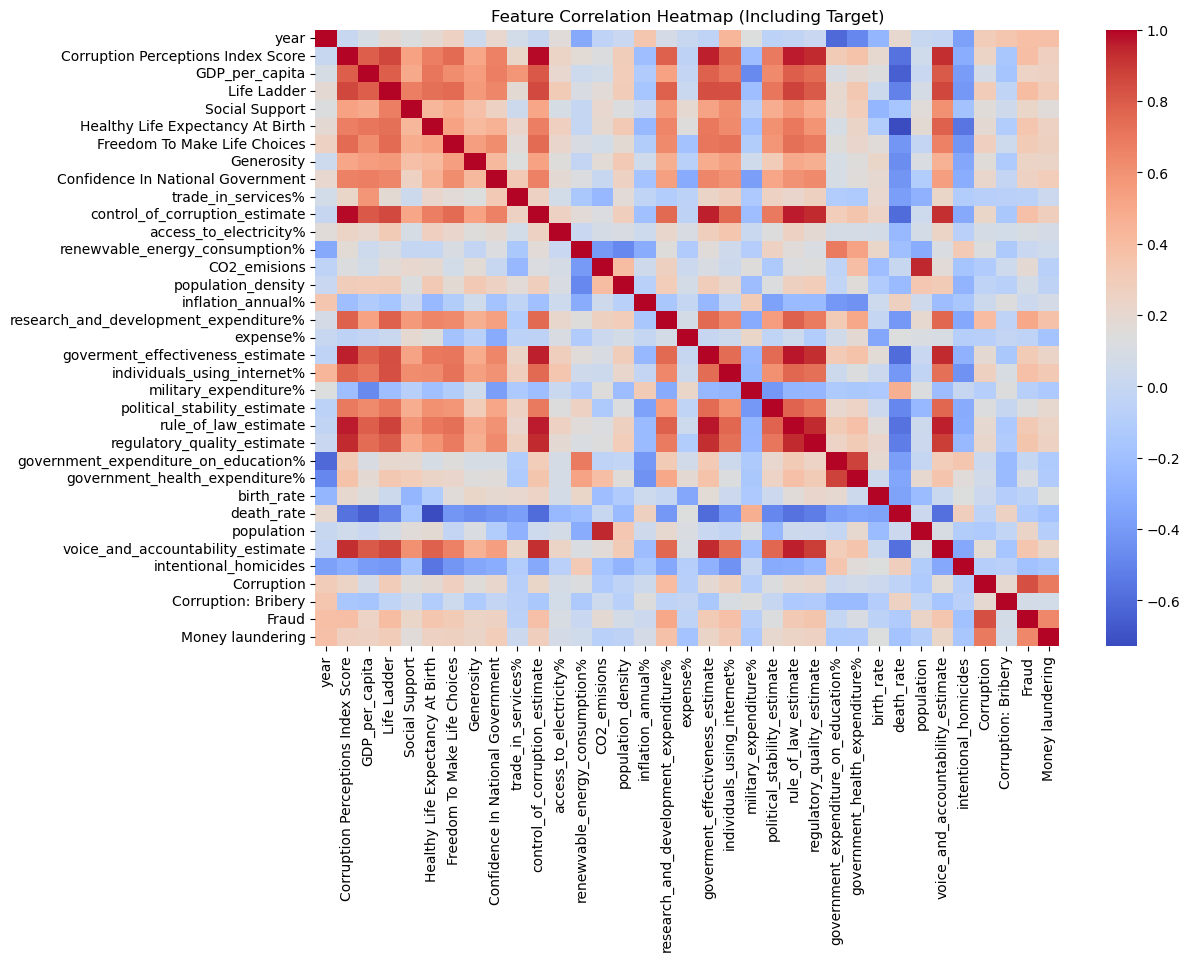


Top Features by Importance:
                                  Feature  Importance
9          control_of_corruption_estimate    0.745293
21                   rule_of_law_estimate    0.229904
28      voice_and_accountability_estimate    0.005150
17       goverment_effectiveness_estimate    0.001343
3                          Social Support    0.001318
18            individuals_using_internet%    0.001049
5            Freedom To Make Life Choices    0.000968
33                       Money laundering    0.000935
4        Healthy Life Expectancy At Birth    0.000923
13                     population_density    0.000817
7       Confidence In National Government    0.000810
27                             population    0.000796
29                  intentional_homicides    0.000794
23   government_expenditure_on_education%    0.000745
2                             Life Ladder    0.000697
1                          GDP_per_capita    0.000693
15  research_and_development_expenditure%    0.000671

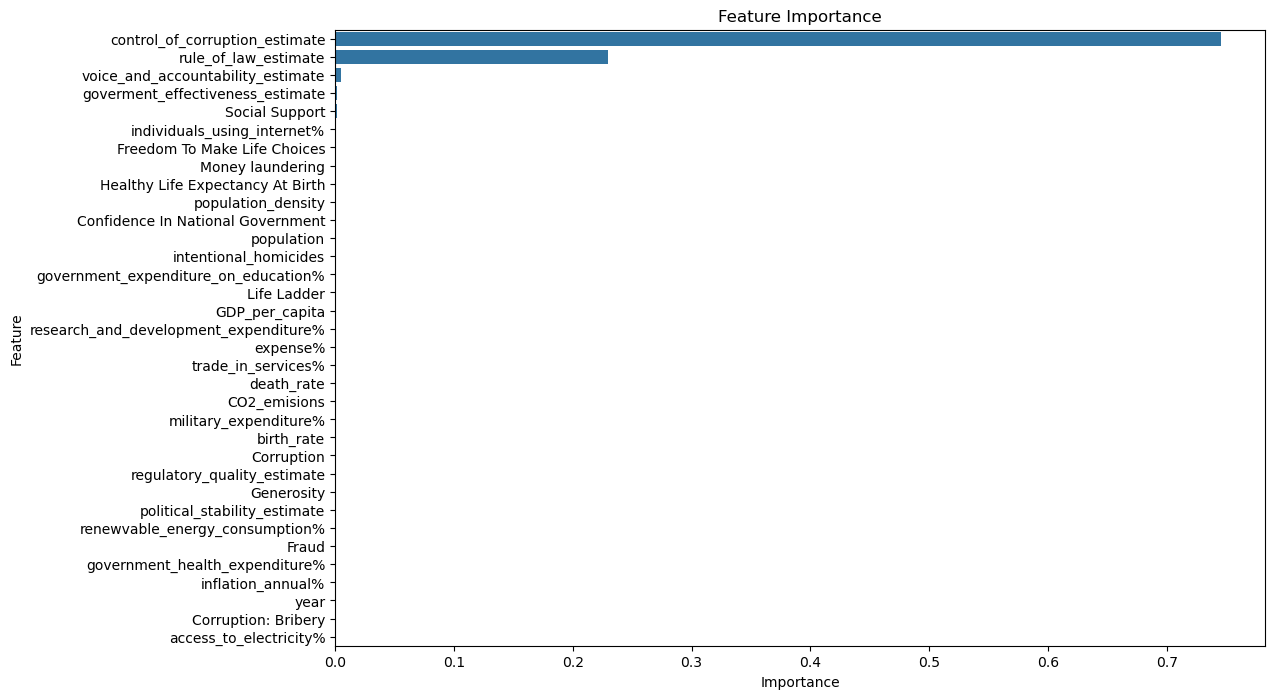

In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def feature_analysis_with_model(data, target_column, model, X_train):
    # Correlation Heatmap
    print("Generating Correlation Heatmap...")
    plt.figure(figsize=(12, 8))
    correlation_matrix = data.corr()
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', cbar=True)
    plt.title("Feature Correlation Heatmap (Including Target)")
    plt.show()

    # Feature Importance from the Pre-Trained Model
    feature_importances = model.feature_importances_
    feature_names = X_train.columns
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': feature_importances
    }).sort_values(by='Importance', ascending=False)

    print("\nTop Features by Importance:")
    print(importance_df)

    # Plot Feature Importance
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title("Feature Importance")
    plt.xlabel("Importance")
    plt.ylabel("Feature")
    plt.show()

feature_analysis_with_model(
    data=data,  
    target_column='Corruption Perceptions Index Score',
    model=best_model,
    X_train=X_train  
)


The model fitting with all features showed good performance. Test Mean Squared Error: 3.6352 and Test R^2 Score: 0.9882.
The ten most important features were 
Top Features by Importance:
                                  Feature  Importance
9          control_of_corruption_estimate    0.745293
21                   rule_of_law_estimate    0.229904
28      voice_and_accountability_estimate    0.005150
17       goverment_effectiveness_estimate    0.001343
3                          Social Support    0.001318
18            individuals_using_internet%    0.001049
5            Freedom To Make Life Choices    0.000968
33                       Money laundering    0.000935
4        Healthy Life Expectancy At Birth    0.000923
13                     population_density    0.000817

Now we try to enhance the model and drop some highly correlating features as well as features that have no impact on the prediction.
Features like control_of_corruption_estimate and rule_of_law_estimate have an enourmous impact, while the others have an importance close to zero. We want to reduce the model to see different correlations too. 

In [64]:
# eexclude Highly Correlated Columns
X_train_reduced = X_train.drop(columns=['control_of_corruption_estimate', 'rule_of_law_estimate'])
X_test_reduced = X_test.drop(columns=['control_of_corruption_estimate', 'rule_of_law_estimate'])

# model with reduced dataset
best_model, best_params = grid_search_random_forest(X_train_reduced, y_train)

print("Best Parameters:", best_params)

# evaluate the Model on the Test Set
y_pred = best_model.predict(X_test_reduced)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")


Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Mean Squared Error: 6.2615
Test R^2 Score: 0.9797


In comparison: Test Mean Squared Error: 3.6352 and Test R^2 Score: 0.9882; the MSE nearly doubled, showing the missing impact from the features we dropped before. 

Generating Correlation Heatmap...


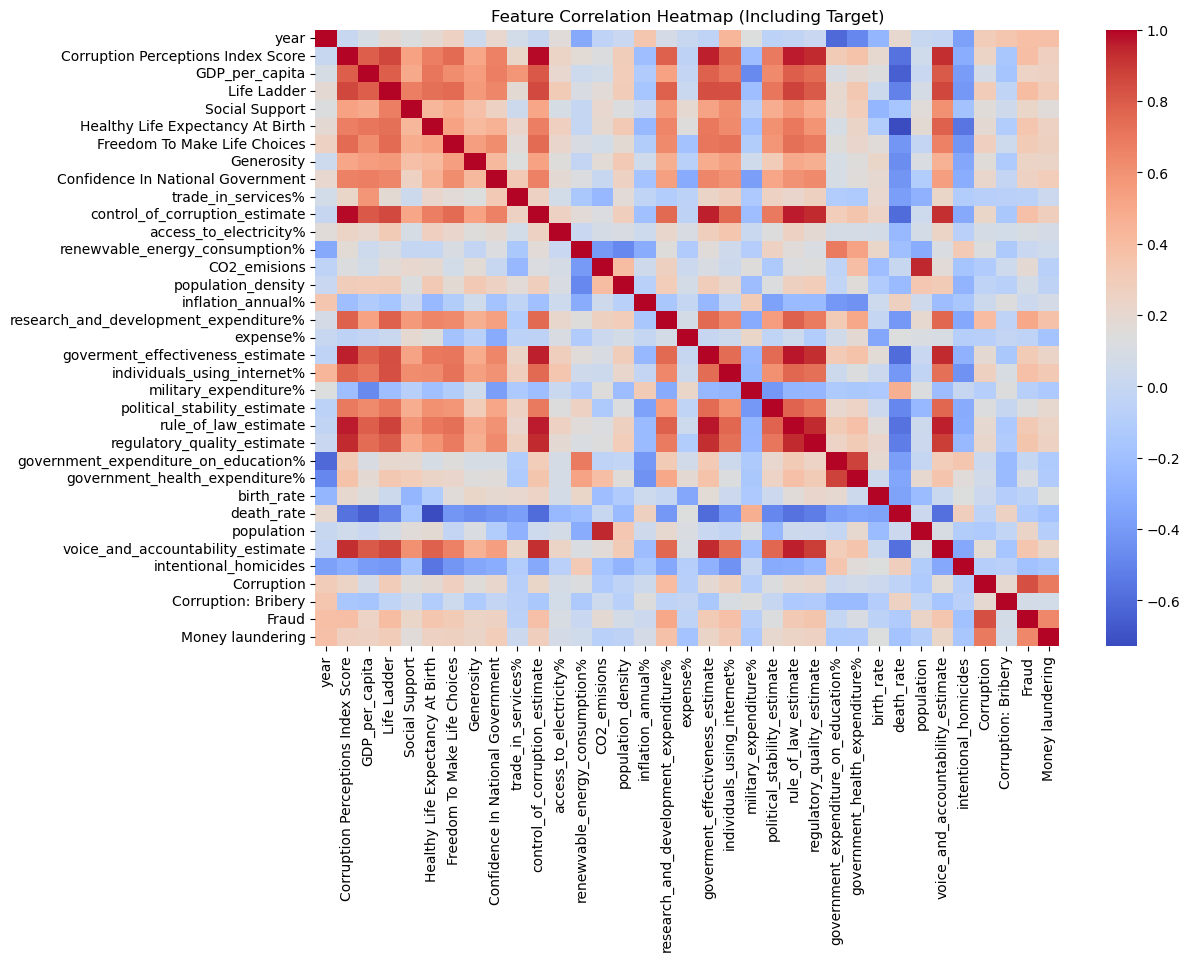


Top Features by Importance:
                                  Feature  Importance
26      voice_and_accountability_estimate    0.742865
16       goverment_effectiveness_estimate    0.149666
1                          GDP_per_capita    0.028267
20            regulatory_quality_estimate    0.026824
17            individuals_using_internet%    0.006702
30                                  Fraud    0.005006
6                              Generosity    0.004348
5            Freedom To Make Life Choices    0.003838
12                     population_density    0.003050
2                             Life Ladder    0.002714
27                  intentional_homicides    0.002642
3                          Social Support    0.002419
4        Healthy Life Expectancy At Birth    0.002305
25                             population    0.001950
15                               expense%    0.001736
11                           CO2_emisions    0.001729
24                             death_rate    0.001447

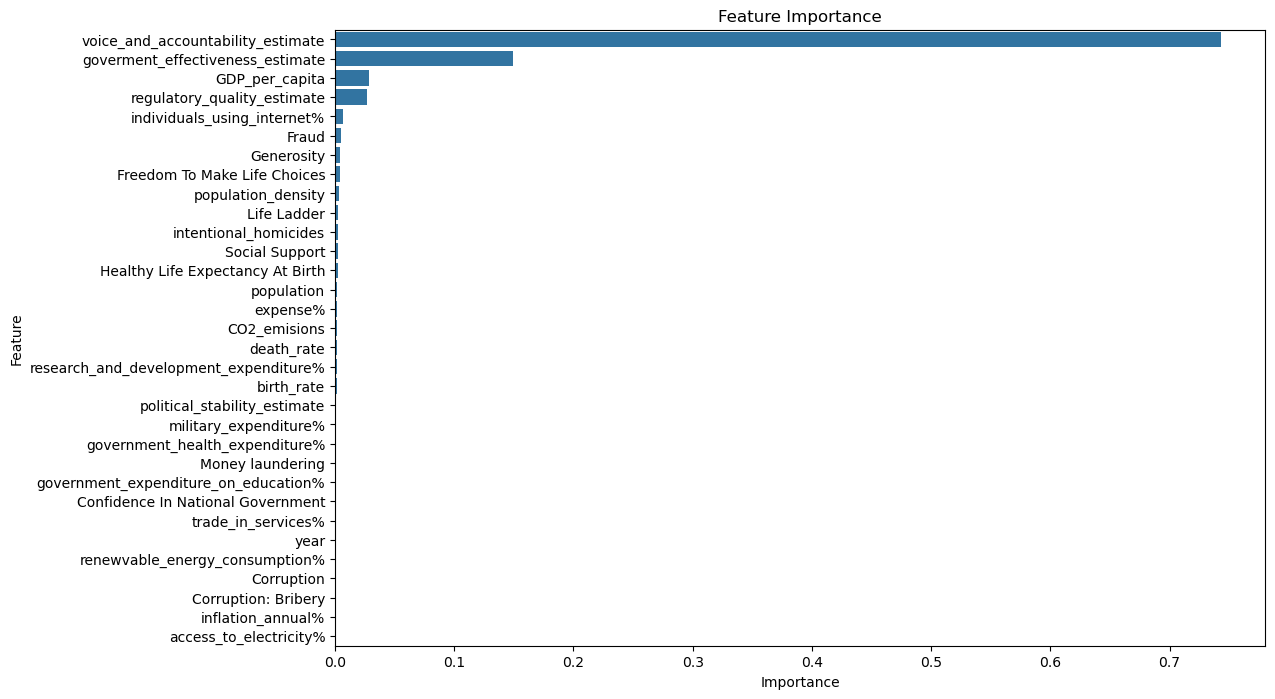

In [65]:
feature_analysis_with_model(
    data=data,  # The full dataset
    target_column='Corruption Perceptions Index Score',
    model=best_model,
    X_train=X_train_reduced  # Features used for training the model
)

Now also other features like GDP show some impartance. 

In [66]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

# Function to drop highly correlated features
def drop_highly_correlated_features(X, threshold=0.9):
    # Compute the correlation matrix
    corr_matrix = X.corr().abs()
    
    # Identify upper triangle of correlation matrix
    upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
    
    # Find features with correlation above the threshold
    to_drop = [column for column in upper_triangle.columns if any(upper_triangle[column] > threshold)]
    
    # Drop the highly correlated features
    return X.drop(columns=to_drop), to_drop


# correlation-based feature filtering
X_train_filtered, dropped_features = drop_highly_correlated_features(X_train_reduced, threshold=0.9)
X_test_filtered = X_test_reduced.drop(columns=dropped_features)  # Ensure the same features are removed from the test set

print(f"Dropped features due to high correlation: {dropped_features}")

best_model, best_params = grid_search_random_forest(X_train_filtered, y_train)
print("Best Parameters:", best_params)

y_pred = best_model.predict(X_test_filtered)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")


Dropped features due to high correlation: ['regulatory_quality_estimate', 'population', 'voice_and_accountability_estimate']
Fitting 5 folds for each of 64 candidates, totalling 320 fits
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}
Test Mean Squared Error: 7.0565
Test R^2 Score: 0.9772


We dropped more features while retaining a similar performance.

In [67]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor

# Function to perform feature selection using Gini importance
def gini_feature_selection(model, X, threshold=0.01):
    # Extract feature importances from the model
    importances = model.feature_importances_
    feature_importances = pd.DataFrame({
        'Feature': X.columns,
        'Importance': importances
    }).sort_values(by='Importance', ascending=False)

    # Filter features based on the threshold
    selected_features = feature_importances[feature_importances['Importance'] >= threshold]
    selected_columns = selected_features['Feature'].tolist()

    # Subset the dataset to include only selected features
    X_selected = X[selected_columns]

    return X_selected, feature_importances

# Apply Gini importance-based feature selection
threshold = 0.001  
X_train_selected, feature_importances = gini_feature_selection(best_model, X_train_filtered, threshold=threshold)

print("Selected Features:")
print(feature_importances[feature_importances['Importance'] >= threshold])

Selected Features:
                                  Feature  Importance
16       goverment_effectiveness_estimate    0.794508
1                          GDP_per_capita    0.138287
27                                  Fraud    0.008608
17            individuals_using_internet%    0.006553
12                     population_density    0.006311
5            Freedom To Make Life Choices    0.004737
3                          Social Support    0.003906
4        Healthy Life Expectancy At Birth    0.003852
24                  intentional_homicides    0.003679
2                             Life Ladder    0.003143
15                               expense%    0.002881
8                      trade_in_services%    0.002774
6                              Generosity    0.002246
20   government_expenditure_on_education%    0.001973
22                             birth_rate    0.001776
23                             death_rate    0.001727
14  research_and_development_expenditure%    0.001696
28       

With gini feature selection we create our final, reduced model.

In [68]:
final_model, final_params = grid_search_random_forest(X_train_selected, y_train)

selected_features = X_train_selected.columns

X_test_selected = X_test_filtered[selected_features]

# Step 4: Evaluate the Model on the Test Set
y_pred = final_model.predict(X_test_selected)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test Mean Squared Error: {mse:.4f}")
print(f"Test R^2 Score: {r2:.4f}")

Fitting 5 folds for each of 64 candidates, totalling 320 fits
Test Mean Squared Error: 6.9440
Test R^2 Score: 0.9775


Generating Correlation Heatmap...


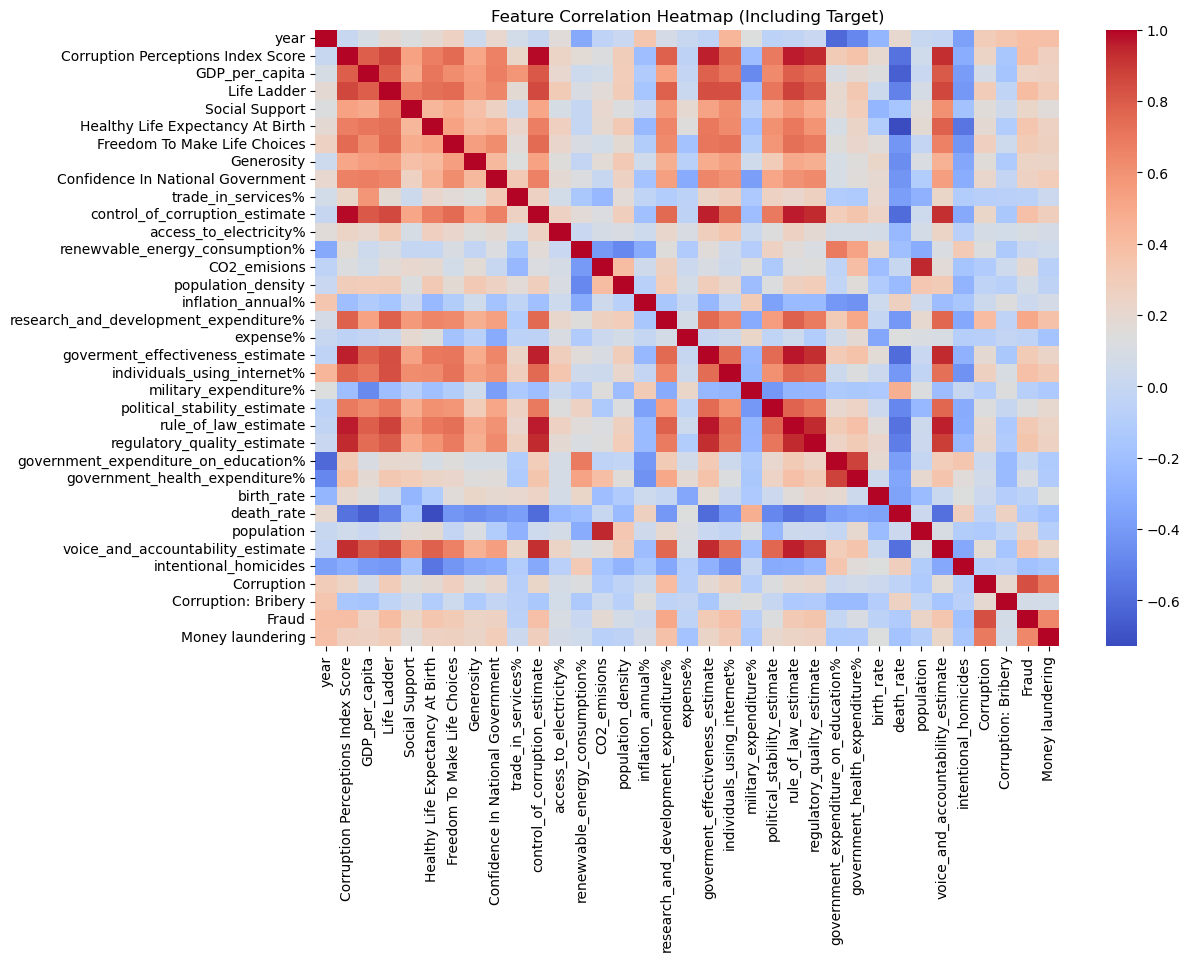


Top Features by Importance:
                                  Feature  Importance
0        goverment_effectiveness_estimate    0.794691
1                          GDP_per_capita    0.138454
2                                   Fraud    0.008915
3             individuals_using_internet%    0.006980
4                      population_density    0.006598
5            Freedom To Make Life Choices    0.005100
7        Healthy Life Expectancy At Birth    0.004163
6                          Social Support    0.003956
8                   intentional_homicides    0.003718
9                             Life Ladder    0.003352
10                               expense%    0.003087
11                     trade_in_services%    0.002860
12                             Generosity    0.002536
15                             death_rate    0.002207
14                             birth_rate    0.002187
13   government_expenditure_on_education%    0.001961
17                       Money laundering    0.001897

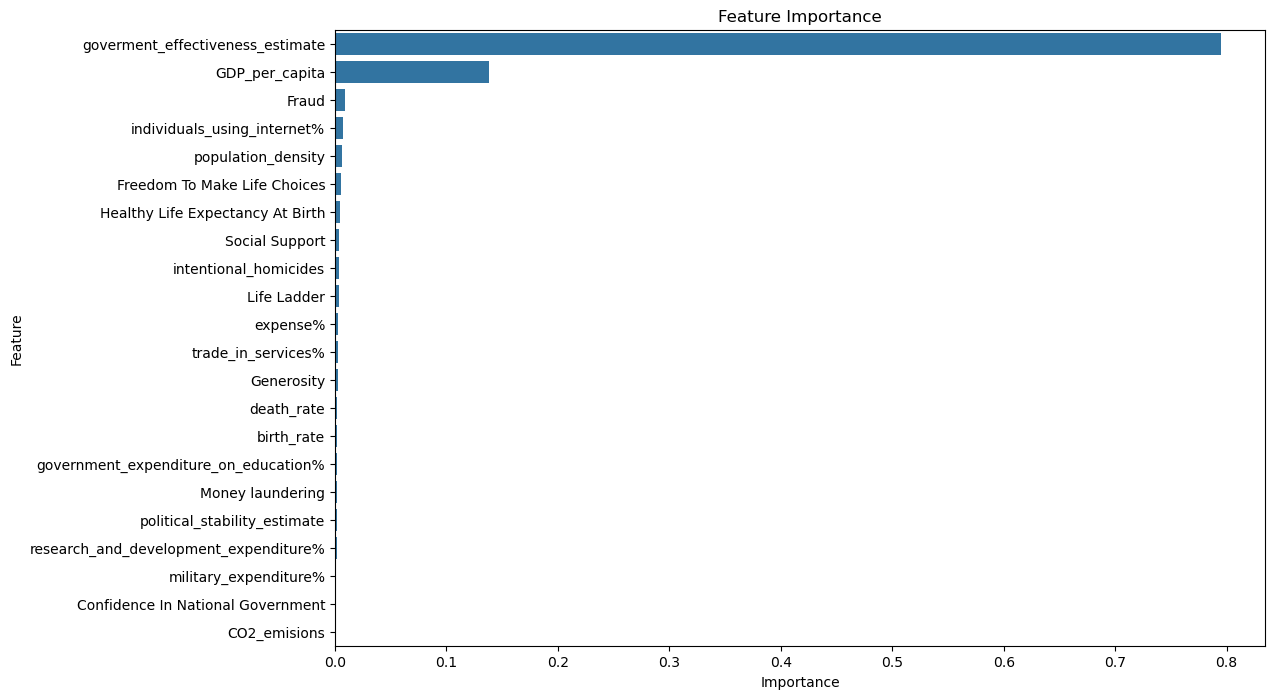

In [69]:
feature_analysis_with_model(
    data=data,  # The full dataset
    target_column='Corruption Perceptions Index Score',
    model=final_model,
    X_train=X_train_selected  # Features used for training the model
)

Compared to the model before, we perform similarly. Our reduced model now depends mostly on government_effective_estimate. 